In [36]:
import collections 
import math 
import os 
import random 
import torch 
from d2l import torch as d2l

In [37]:
#@save 
d2l.DATA_HUB['ptb'] = (d2l.DATA_URL + 'ptb.zip', '319d85e578af0cdc590547f26231e4e31cdf1e42')

def read_ptb():
    data_dir = d2l.download_extract('ptb')
    with open(os.path.join(data_dir, 'ptb.train.txt')) as f:
        raw_text = f.read()
    return [line.split() for line in raw_text.split('\n')]

sentences = read_ptb()
f'# sentences: {len(sentences)}'

'# sentences: 42069'

In [38]:
# Build vocabulary for the corpus
vocab = d2l.Vocab(sentences, min_freq=10) 
f'vocab size: {len(vocab)}'

'vocab size: 6719'

In [39]:
def subsample(sentences, vocab):
    #Exclude unknown tokens <unk>
    sentences = [[token for token in line if vocab[token] != vocab.unk]
                 for line in sentences]
    counter = collections.Counter([
        token for line in sentences for token in line
    ])
    num_tokens = sum(counter.values())
    
    #Return True if token is kept during subsampling
    def keep(token):
        return (random.uniform(0,1)<math.sqrt(1e-4/counter[token]*num_tokens))
    return ([[token for token in line if keep(token)] for line in sentences], counter)

subsampled, counter = subsample(sentences, vocab)

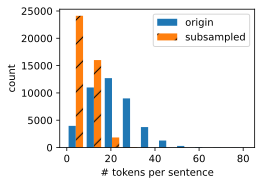

In [40]:
d2l.show_list_len_pair_hist(['origin', 'subsampled'], 
                            '# tokens per sentence', 'count', sentences, subsampled);

In [41]:
def compare_counts(token):
    return (f'# of "{token}": '
            f'before={sum([l.count(token) for l in sentences])}, '
            f'after={sum([l.count(token) for l in subsampled])}')
 
compare_counts('the') # high frequency wors

'# of "the": before=50770, after=2060'

In [42]:
compare_counts('join') # low frequency words

'# of "join": before=45, after=45'

In [43]:
corpus = [vocab[line] for line in subsampled] 
corpus[:3]

[[], [4127, 6612, 3228, 416], [993, 3922, 1922, 4743]]

In [44]:
def get_centers_and_contexts(corpus, max_window_size):
    centers, contexts = [], []
    for line in corpus:
        # to form "center-context word" pair, each sent needs to have at least 2 words
        if len(line) <2: continue
        centers += line
        for i in range(len(line)):
            window_size = random.randint(1, max_window_size)
            indices = list(range(max(0, i - window_size), min(len(line), i + 1 + window_size)))
            # exclude center word
            indices.remove(i)
            contexts.append([line[idx] for idx in indices])
    return centers, contexts
            

In [45]:
tiny_dataset = [list(range(7)), list(range(7, 10))] 
print('dataset', tiny_dataset) 
for center, context in zip(*get_centers_and_contexts(tiny_dataset, 2)):
    print('center', center, 'has contexts', context)

dataset [[0, 1, 2, 3, 4, 5, 6], [7, 8, 9]]
center 0 has contexts [1]
center 1 has contexts [0, 2]
center 2 has contexts [1, 3]
center 3 has contexts [2, 4]
center 4 has contexts [3, 5]
center 5 has contexts [3, 4, 6]
center 6 has contexts [4, 5]
center 7 has contexts [8]
center 8 has contexts [7, 9]
center 9 has contexts [7, 8]


In [46]:
all_centers, all_contexts = get_centers_and_contexts(corpus, 5) 
f'# center-context pairs: {sum([len(contexts) for contexts in all_contexts])}'

'# center-context pairs: 1499949'

In [47]:
class RandomGenerator:
    def __init__(self, sampling_weights):
        self.population = list(range(1, len(sampling_weights)+1))
        self.sampling_weights=sampling_weights
        self.candidates=[]
        self.i = 0
        
    def draw(self):
        if self.i==len(self.candidates):
            self.candidates=random.choices(
                self.population, self.sampling_weights, k=10000)
            self.i=0
        self.i+=1
        return self.candidates[self.i-1]

In [48]:
def get_negatives(all_contexts, vocab, counter, K):
    # Return noise wors in negative sampling
    # sampling weights for words with indices 1, 2,.... in the vocabulary
    sampling_weights = [counter[vocab.to_tokens(i)] ** 0.75
                        for i in range(1, len(vocab))]
    all_negatives, generator = [], RandomGenerator(sampling_weights)
    for contexts in all_contexts:
        negatives=[]
        while len(negatives)<len(contexts)*K:
            neg=generator.draw()
            if neg not in contexts:
                negatives.append(neg)
        all_negatives.append(negatives)
    return all_negatives

all_negatives = get_negatives(all_contexts, vocab, counter, 5)

In [49]:
def batchify(data):
    max_len = max(len(c) + len(n) for _, c, n in data)
    centers, contexts_negatives, masks, labels = [], [], [], []
    for center, context, negative in data:
        cur_len = len(context) + len(negative)
        centers += [center]
        contexts_negatives += [context + negative + [0]*(max_len - cur_len)] #padding
        masks += [[1]*cur_len + [0]*(max_len-cur_len)]
        labels+= [[1]*len(context) + [0]*(max_len-len(context))]
    return (torch.tensor(centers).reshape((-1,1)), torch.tensor(
        contexts_negatives), torch.tensor(masks), torch.tensor(labels))

In [50]:
x_1 = (1, [2, 2], [3, 3, 3, 3]) 
x_2 = (1, [2, 2, 2], [3, 3]) 
batch = batchify((x_1, x_2))
names = ['centers', 'contexts_negatives', 'masks', 'labels'] 
for name, data in zip(names, batch):
    print(name, '=', data)

centers = tensor([[1],
        [1]])
contexts_negatives = tensor([[2, 2, 3, 3, 3, 3],
        [2, 2, 2, 3, 3, 0]])
masks = tensor([[1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0]])
labels = tensor([[1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0]])


In [51]:
def load_data_ptb(batch_size, max_window_size, num_noise_words):
    num_workers = d2l.get_dataloader_workers() 
    sentences = read_ptb() 
    vocab = d2l.Vocab(sentences, min_freq=10) 
    subsampled, counter = subsample(sentences, vocab) 
    corpus = [vocab[line] for line in subsampled] 
    all_centers, all_contexts = get_centers_and_contexts( corpus, max_window_size) 
    all_negatives = get_negatives( all_contexts, vocab, counter, num_noise_words)

    class PTBDataset(torch.utils.data.Dataset):
        def __init__(self, centers, contexts, negatives):
            assert len(centers) == len(contexts) == len(negatives) 
            self.centers = centers 
            self.contexts = contexts 
            self.negatives = negatives
        def __getitem__(self, index):
            return (self.centers[index], self.contexts[index], self.negatives[index])
        def __len__(self):
            return len(self.centers)
    dataset = PTBDataset(all_centers, all_contexts, all_negatives)
    data_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True,
                                            collate_fn=batchify, num_workers=num_workers) 
    return data_iter, vocab

In [52]:
data_iter, vocab = load_data_ptb(512, 5, 5) 
for batch in data_iter:
    for name, data in zip(names, batch):
        print(name, 'shape:', data.shape) 
    break

centers shape: torch.Size([512, 1])
contexts_negatives shape: torch.Size([512, 60])
masks shape: torch.Size([512, 60])
labels shape: torch.Size([512, 60])


In [53]:
import math 
import torch 
from torch import nn 
from d2l import torch as d2l

batch_size, max_window_size, num_noise_words = 512, 5, 5 
data_iter, vocab = d2l.load_data_ptb(batch_size, max_window_size, num_noise_words)

In [54]:
embed = nn.Embedding(num_embeddings=20, embedding_dim=4) 
print(f'Parameter embedding_weight ({embed.weight.shape}, ' f'dtype={embed.weight.dtype})')

Parameter embedding_weight (torch.Size([20, 4]), dtype=torch.float32)


In [55]:
x = torch.tensor([[1,2,3], [4,5,6]])
embed(x)

tensor([[[ 0.6461, -0.4722,  0.2844, -0.9202],
         [-1.9165, -0.9948, -0.3259, -1.4599],
         [-1.3316,  0.9367, -0.8074, -1.4165]],

        [[-0.6379, -0.3009, -0.6728, -1.4145],
         [ 1.0982,  0.5086,  0.9558, -0.9376],
         [ 0.2653, -1.1132,  0.0567,  1.5190]]], grad_fn=<EmbeddingBackward0>)

In [56]:
def skip_gram(center, contexts_and_negatives, embed_v, embed_u):
    v = embed_v(center)
    u = embed_u(contexts_and_negatives)
    pred = torch.bmm(v, u.permute(0,2,1))
    return pred

In [57]:
skip_gram(torch.ones((2,1), dtype=torch.long), 
          torch.ones((2,4), dtype=torch.long), embed, embed).shape

torch.Size([2, 1, 4])

In [58]:
class SigmoidBCELoss(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, inputs, target, mask=None):
        out = nn.functional.binary_cross_entropy_with_logits(
            inputs, target, weight=mask, reduction="none")
        return out.mean(dim=1)
    
loss = SigmoidBCELoss()

In [59]:
pred = torch.tensor([[1.1, -2.2, 3.3, -4.4]] * 2) 
label = torch.tensor([[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0]]) 
mask = torch.tensor([[1, 1, 1, 1], [1, 1, 0, 0]]) 
loss(pred, label, mask) * mask.shape[1] / mask.sum(axis=1)

tensor([0.9352, 1.8462])

In [60]:
def sigmd(x):
    return -math.log(1/(1+math.exp(-x)))

print(f'{(sigmd(1.1) + sigmd(2.2) + sigmd(-3.3) + sigmd(4.4)) / 4:.4f}')
print(f'{(sigmd(-1.1) + sigmd(-2.2)) / 2:.4f}')

0.9352
1.8462


In [61]:
embed_size = 100
net = nn.Sequential(nn.Embedding(num_embeddings=len(vocab),
                                 embedding_dim=embed_size),
                    nn.Embedding(num_embeddings=len(vocab),
                                 embedding_dim=embed_size))

In [62]:
def train(net, data_iter, lr, num_epochs, device=d2l.try_gpu()):
    def init_weights(module):
        if type(module) == nn.Embedding:
            nn.init.xavier_uniform_(module.weight)
    net.apply(init_weights)
    net = net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, num_epochs])
    metric = d2l.Accumulator(2)
    for epoch in range(num_epochs):
        timer, num_batches = d2l.Timer(), len(data_iter)
        for i, batch in enumerate(data_iter):
            optimizer.zero_grad()
            center, context_negative, mask, label = [data.to(device) for data in batch]
            pred = skip_gram(center, context_negative, net[0], net[1])
            l = (loss(pred.reshape(label.shape).float(), label.float(), mask)
                 /mask.sum(axis=1)*mask.shape[1])
            l.sum().backward()
            optimizer.step()
            metric.add(l.sum(), l.numel())
            if (i+1)%(num_batches//5)==0 or i ==num_batches-1:
                animator.add(epoch+(i+1)/num_batches, (metric[0]/metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, ' f'{metric[1] / timer.stop():.1f} tokens/sec on {str(device)}')

KeyboardInterrupt: 

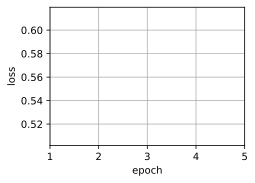

In [64]:
lr, num_epochs = 0.002, 5 
train(net, data_iter, lr, num_epochs)

In [ ]:
import collections

symbols = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '_', '[UNK]']

raw_token_freqs = {'fast_': 4, 'faster_': 3, 'tall_': 5, 'taller_': 4} 
token_freqs = {} 
for token, freq in raw_token_freqs.items():
    token_freqs[' '.join(list(token))] = raw_token_freqs[token] 
token_freqs

{'f a s t _': 4, 'f a s t e r _': 3, 't a l l _': 5, 't a l l e r _': 4}

In [ ]:
def get_simliar_tokens(query_token, k, embed):
    W = embed.weight.data
    x = W[vocab[query_token]]
    # compute cosine similarity
    cos = torch.mv(W, x) / torch.sqrt(torch.sum(W*W, dim=1)*torch.sum(x*x)+1e-9)
    topk = torch.topk(cos, k=k+1)[1].cpu().numpy().astype('int32')
    for i in topk[1:]:
        print(f'cosine sim={float(cos[i]):.3f}: {vocab.to_tokens(i)}')
get_simliar_tokens('chip', 3, net[0])

cosine sim=0.668: microprocessor
cosine sim=0.636: bugs
cosine sim=0.629: intel


In [ ]:
def get_max_freq_pair(token_freqs):
    pairs = collections.defaultdict(int)
    for token, freq in token_freqs.items():
        symbols = token.split()
        for i in range(len(symbols)-1):
            pairs[symbols[i], symbols[i+1]] += freq
    return max(pairs, key=pairs.get) #key of pairs with max value

In [ ]:
def merge_symbols(max_freq_pair, token_freqs, symbols):
    symbols.append(''.join(max_freq_pair))
    new_token_freqs = dict()
    for token, freq in token_freqs.items():
        new_token = token.replace(' '.join(max_freq_pair),
                                  ''.join(max_freq_pair))
        new_token_freqs[new_token] = token_freqs[token]
    return new_token_freqs

In [ ]:
num_merges = 10
for i in range(num_merges):
    max_freq_pair = get_max_freq_pair(token_freqs)
    token_freqs = merge_symbols(max_freq_pair, token_freqs, symbols)
    print(f'merge #{i + 1}:', max_freq_pair)

merge #1: ('t', 'a')
merge #2: ('ta', 'l')
merge #3: ('tal', 'l')
merge #4: ('f', 'a')
merge #5: ('fa', 's')
merge #6: ('fas', 't')
merge #7: ('e', 'r')
merge #8: ('er', '_')
merge #9: ('tall', '_')
merge #10: ('fast', '_')


In [ ]:
print(symbols)

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '_', '[UNK]', 'ta', 'tal', 'tall', 'fa', 'fas', 'fast', 'er', 'er_', 'tall_', 'fast_']


In [ ]:
print(list(token_freqs.keys()))

['fast_', 'fast er_', 'tall_', 'tall er_']


In [ ]:
def segment_BPE(tokens, symbols):
    outputs = []
    for token in tokens:
        start, end = 0, len(token)
        cur_output = []
        # segment token with the longest possible subwords from symbols
        while start<len(token) and start<end:
            if token[start: end] in symbols:
                cur_output.append(token[start: end])
                start = endend = len(token)
            else: 
                end -= 1
        if start<len(token):
            cur_output.append('[UNK]')
        outputs.append(' '.join(cur_output))
    return outputs

In [ ]:
tokens = ['tallest_', 'fatter_'] 
print(segment_BPE(tokens, symbols))

['tall', 'fa']


In [ ]:
import os 
import torch 
from torch import nn 
from d2l import torch as d2l

In [65]:
#@save 
d2l.DATA_HUB['glove.6b.50d'] = (d2l.DATA_URL + 'glove.6B.50d.zip', '0b8703943ccdb6eb788e6f091b8946e82231bc4d')

#@save 
d2l.DATA_HUB['glove.6b.100d'] = (d2l.DATA_URL + 'glove.6B.100d.zip', 'cd43bfb07e44e6f27cbcc7bc9ae3d80284fdaf5a')

#@save 
d2l.DATA_HUB['glove.42b.300d'] = (d2l.DATA_URL + 'glove.42B.300d.zip', 'b5116e234e9eb9076672cfeabf5469f3eec904fa')

#@save 
d2l.DATA_HUB['wiki.en'] = (d2l.DATA_URL + 'wiki.en.zip', 'c1816da3821ae9f43899be655002f6c723e91b88')

In [66]:
class TokenEmbedding:
    def __init__(self, embedding_name):
        self.idx_to_token, self.idx_to_vec = self._load_embedding( embedding_name) 
        self.unknown_idx = 0 
        self.token_to_idx = {token: idx for idx, token in enumerate(self.idx_to_token)}

    def _load_embedding(self, embedding_name):
        idx_to_token, idx_to_vec = ['<unk>'], [] 
        data_dir = d2l.download_extract(embedding_name) 
        with open(os.path.join(data_dir, 'vec.txt'), 'r') as f:
            for line in f:
                elems = line.rstrip().split(' ')
                token, elems = elems[0], [float(elem) for elem in elems[1:]]
                if len(elems) > 1:
                    idx_to_token.append(token) 
                    idx_to_vec.append(elems)
        idx_to_vec = [[0] * len(idx_to_vec[0])] + idx_to_vec
        return idx_to_token, torch.tensor(idx_to_vec)

    def __getitem__(self, tokens):
        indices = [self.token_to_idx.get(token, self.unknown_idx) for token in tokens] 
        vecs = self.idx_to_vec[torch.tensor(indices)] 
        return vecs
    def __len__(self):
        return len(self.idx_to_token)

glove_6b50d = TokenEmbedding('glove.6b.50d')

In [67]:
len(glove_6b50d)

400001

In [ ]:
glove_6b50d.token_to_idx['beautiful'], glove_6b50d.idx_to_token[3367]

(3367, 'beautiful')

In [68]:
def knn(W, x, k):
    cos = torch.mv(W, x.reshape(-1,))/(torch.sqrt(torch.sum(W*W, axis=1)+1e-9)*
                                       torch.sqrt((x*x).sum()))
    _, topk = torch.topk(cos, k=k)
    return topk, [cos[int(i)] for i in topk]

In [69]:
def get_similar_tokens(query_token, k, embed):
    topk, cos = knn(embed.idx_to_vec, embed[[query_token]], k+1)
    for i, c in zip(topk[1:], cos[1:]):
        print(f'cosine sim={float(c):.3f}: {embed.idx_to_token[int(i)]}')

In [70]:
get_similar_tokens('chip', 3, glove_6b50d)

cosine sim=0.856: chips
cosine sim=0.749: intel
cosine sim=0.749: electronics


In [71]:
get_similar_tokens('baby', 3, glove_6b50d)

cosine sim=0.839: babies
cosine sim=0.800: boy
cosine sim=0.792: girl


In [72]:
get_similar_tokens('beautiful', 3, glove_6b50d)

cosine sim=0.921: lovely
cosine sim=0.893: gorgeous
cosine sim=0.830: wonderful


In [73]:
def get_analogy(token_a, token_b, token_c, embed):
    vecs = embed[[token_a, token_b, token_c]]
    x = vecs[1] - vecs[0] + vecs[2]
    topk, cos = knn(embed.idx_to_vec, x, 1) 
    return embed.idx_to_token[int(topk[0])]

In [ ]:
get_analogy('man', 'woman', 'son', glove_6b50d)

'daughter'

In [ ]:
get_analogy('beijing', 'china', 'tokyo', glove_6b50d)

'japan'

In [ ]:
get_analogy('bad', 'worst', 'big', glove_6b50d)

'biggest'

In [ ]:
get_analogy('do', 'did', 'go', glove_6b50d)

'went'

In [ ]:
import torch 
from torch import nn 
from d2l import torch as d2l

In [ ]:
def get_tokens_and_segments(tokens_a, tokens_b=None):
    tokens = ['<cls>'] + tokens_a + ['<sep>']
    segments = [0] * (len(tokens_a)+2)
    if tokens_b is not None:
        tokens += tokens_b + ['<sep>']
        segments += [1] * (len(tokens_b)+1)
    return tokens, segments

In [74]:
class BERTEncoder(nn.Module):
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens, num_heads,
                 num_blks, dropout, max_len=1000, **kwargs):
        super(BERTEncoder, self).__init__(**kwargs)
        self.token_embedding = nn.Embedding(vocab_size, num_hiddens)
        self.segment_embedding = nn.Embedding(2, num_hiddens)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module(f"{i}", d2l.TransformerEncoderBlock(
                num_hiddens, ffn_num_hiddens, num_heads, dropout, True))
        self.pos_embedding = nn.Parameter(torch.randn(1, max_len, num_hiddens))
        # positional embeddings are learnable, thus create parameter
        
    def forward(self, tokens, segments, valid_lens):
        X = self.token_embedding(tokens)+self.segment_embedding(segments)
        X = X + self.pos_embedding[:, :X.shape[1], :]
        for blk in self.blks:
            X = blk(X, valid_lens)
        return X

In [75]:
vocab_size, num_hiddens, ffn_num_hiddens, num_heads = 10000, 768, 1024, 4 
ffn_num_input, num_blks, dropout = 768, 2, 0.2 
encoder = BERTEncoder(vocab_size, num_hiddens, ffn_num_hiddens, num_heads, num_blks, dropout)

/home/shkim/anaconda3/envs/d2l/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [76]:
tokens = torch.randint(0, vocab_size, (2, 8)) 
segments = torch.tensor([[0, 0, 0, 0, 1, 1, 1, 1], [0, 0, 0, 1, 1, 1, 1, 1]]) 
encoded_X = encoder(tokens, segments, None) 
encoded_X.shape

torch.Size([2, 8, 768])

In [77]:
class MaskLM(nn.Module):
    def __init__(self, vocab_size, num_hiddens, **kwargs):
        super(MaskLM, self).__init__(**kwargs)
        self.mlp = nn.Sequential(nn.LazyLinear(num_hiddens),
                                 nn.ReLU(), 
                                 nn.LayerNorm(num_hiddens),
                                 nn.LazyLinear(vocab_size))
    
    def forward(self, X, pred_positions):
        num_pred_positions = pred_positions.shape[1]
        pred_positions = pred_positions.reshape(-1)
        batch_size = X.shape[0]
        batch_idx = torch.arange(0, batch_size)
        batch_idx = torch.repeat_interleave(batch_idx, num_pred_positions)
        masked_X = X[batch_idx, pred_positions]
        masked_X = masked_X.reshape((batch_size, num_pred_positions, -1))
        mlm_Y_hat = self.mlp(masked_X)
        return mlm_Y_hat

In [ ]:
mlm = MaskLM(vocab_size, num_hiddens) 
mlm_positions = torch.tensor([[1, 5, 2], [6, 1, 5]]) 
mlm_Y_hat = mlm(encoded_X, mlm_positions) 
mlm_Y_hat.shape

torch.Size([2, 3, 10000])

In [ ]:
mlm_Y = torch.tensor([[7, 8, 9], [10, 20, 30]]) 
loss = nn.CrossEntropyLoss(reduction='none') 
mlm_l = loss(mlm_Y_hat.reshape((-1, vocab_size)), mlm_Y.reshape(-1)) 
mlm_l.shape

torch.Size([6])

In [78]:
class NextSentencePred(nn.Module):
    def __init__(self, **kwargs):
        super(NextSentencePred, self).__init__(**kwargs)
        self.output = nn.LazyLinear(2)
    def forward(self, X):
        return self.output(X)

In [ ]:
encoded_X = torch.flatten(encoded_X, start_dim=1)
nsp = NextSentencePred()
nsp_Y_hat = nsp(encoded_X)
nsp_Y_hat.shape

torch.Size([2, 2])

In [ ]:
nsp_y = torch.tensor([0,1])
nsp_l = loss(nsp_Y_hat, nsp_y)
nsp_l.shape

torch.Size([2])

In [79]:
class BERTModel(nn.Module):
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens,
                 num_heads, num_blks, dropout, max_len=1000):
        super(BERTModel, self).__init__()
        self.encoder = BERTEncoder(vocab_size, num_hiddens, ffn_num_hiddens,
                                   num_heads, num_blks, dropout, max_len=max_len)
        self.hidden = nn.Sequential(nn.LazyLinear(num_hiddens), nn.Tanh())
        self.mlm = MaskLM(vocab_size, num_hiddens)
        self.nsp = NextSentencePred()
    
    def forward(self, tokens, segments, valid_lens =None, pred_positions=None):
        encoded_X = self.encoder(tokens, segments, valid_lens)
        if pred_positions is not None:
            mlm_Y_hat = self.mlm(encoded_X, pred_positions)
        else:
            mlm_Y_hat = None
        # 0 is the index of the '<cls>' token
        nsp_Y_hat = self.nsp(self.hidden(encoded_X[:, 0, :]))
        return encoded_X, mlm_Y_hat, nsp_Y_hat

In [80]:
import os 
import random 
import torch 
from d2l import torch as d2l

In [81]:
d2l.DATA_HUB['wikitext-2'] = ('https://s3.amazonaws.com/research.metamind.io/wikitext/' 'wikitext-2-v1.zip', '3c914d17d80b1459be871a5039ac23e752a53cbe')

def _read_wiki(data_dir):
    file_name = os.path.join(data_dir, 'wiki.train.tokens')
    with open(file_name, 'r') as f:
        lines = f.readlines
    paragraphs = [line.strip().lower().splie(' . ') for line in lines
                  if len(line.split(' . ')) >= 2]
    random.shuffle(paragraphs)
    return paragraphs

In [82]:
def _get_next_sentence(sentence, next_sentence, paragraphs):
    if random.random() < 0.5:
        is_next = True
    else:
        next_sentence = random.choice(random.choice(paragraphs))
        is_next = False
    return sentence, next_sentence, is_next

def _get_nsp_data_from_paragraph(paragraph, paragraphs, vocab, max_len):
    nsp_data_from_paragraph = []
    for i in range(len(paragraph)-1):
        tokens_a, tokens_b, is_next = _get_next_sentence(
            paragraph[i], paragraph[i+1], paragraphs)
        if len(tokens_a)+len(tokens_b)+3>max_len: # <cls> and 2 <sep> tokens
            continue
        tokens, segments = d2l.get_tokens_and_segments(tokens_a, tokens_b)
        nsp_data_from_paragraph.append((tokens, segments, is_next))
    return nsp_data_from_paragraph            

In [83]:
def _replace_mlm_tokens(tokens, candidate_pred_positions, num_mlm_preds, vocab):
    mlm_input_tokens = [token for token in tokens] # new copy
    pred_positions_and_labels = []
    # shuffle for 15% random tokens
    random.shuffle(candidate_pred_positions)
    for mlm_pred_position in candidate_pred_positions:
        if len(pred_positions_and_labels)>= num_mlm_preds:
            break
        masked_token = None
        # 80%: replace word with <mask>
        if random.random() < 0.8:
            masked_token = '<mask>'
        else:
            # 10%: keep the word unchanged
            if random.random() < 0.5:
                masked_token = tokens[mlm_pred_position]
            # 10%: replace with a random word
            else: 
                masked_token = random.choice(vocab.idx_to_token)
        mlm_input_tokens[mlm_pred_position] = masked_token
        pred_positions_and_labels.append((mlm_pred_position, tokens[mlm_pred_position]))
    return mlm_input_tokens, pred_positions_and_labels

In [84]:
def _get_mlm_data_from_tokens(tokens, vocab):
    candidate_pred_positions = []
    for i, token in enumerate(tokens):
        if token in ['<cls>', '<sep']:
            continue
        candidate_pred_positions.append(i)
    # 15% of random tokens are predicted in mlm task
    num_mlm_preds = max(1, round(len(tokens)*0.15))
    mlm_input_tokens, pred_positions_and_labels = _replace_mlm_tokens(
        tokens, candidate_pred_positions, num_mlm_preds, vocab)
    pred_positions_and_labels = sorted(pred_positions_and_labels, 
                                       key=lambda x: x[0])
    pred_positions = [v[0] for v in pred_positions_and_labels]
    mlm_pred_lables = [v[1] for v in pred_positions_and_labels]
    return vocab[mlm_input_tokens], pred_positions, vocab[mlm_pred_lables]

In [85]:
def _pad_bert_inputs(examples, max_len, vocab):
    max_num_mlm_preds = round(max_len*0.15)
    all_token_ids, all_segments, valid_lens, = [], [], []
    all_pred_positions, all_mlm_weights, all_mlm_labels = [], [], []
    nsp_labels = []
    for (token_ids, pred_positions, mlm_pred_label_ids, segments, is_next) in examples:
        all_token_ids.append(
            torch.tensor(token_ids + [vocab['<pad>']] * (max_len-len(token_ids)), dtype=torch.long))
        all_segments.append(torch.tensor(segments + [0]*(max_len - len(segments)), dtype=torch.long))
        # valid_lens excludes count of <pad>
        valid_lens.append(torch.tensor(len(token_ids), dtype=torch.fload32))
        all_pred_positions.append(torch.tensor(pred_positions+[0]*(
            max_num_mlm_preds-len(pred_positions)), dtype=torch.long))
        # predictions of padded tokens will be filtered out in the loss vida multiplication of 0 weights
        all_mlm_weights.append(
            torch.tensor([1.0] * len[mlm_pred_label_ids] + 
                         [0.0]*(max_num_mlm_preds-len(pred_positions)), dtype=torch.float32))
        all_mlm_labels.append(
            torch.tensor(mlm_pred_label_ids+[0]*(max_num_mlm_preds-len(mlm_pred_label_ids)), dtype=torch.long))
        nsp_labels.append(torch.tensor(is_next, dtype=torch.long))
    return (all_token_ids, all_segments, valid_lens, all_pred_positions, all_mlm_weights, all_mlm_labels, nsp_labels)
         

In [86]:
class _WikiTextDataset(torch.utils.data.Dataset):
    def __init__(self, paragraphs, max_len):
        paragraphs = [d2l.tokenize(paragraph, token='word') for paragraph in paragraphs] 
        sentences = [sentence for paragraph in paragraphs for sentence in paragraph]
        self.vocab = d2l.Vocab(sentences, min_freq=5, reserved_tokens=[
        '<pad>', '<mask>', '<cls>', '<sep>']) 
        # Get data for the next sentence prediction task 
        examples = [] 
        for paragraph in paragraphs:
            examples.extend(_get_nsp_data_from_paragraph(
                paragraph, paragraphs, self.vocab, max_len)) 
        # Get data for the masked language model task
        examples = [(_get_mlm_data_from_tokens(tokens, self.vocab)
                + (segments, is_next)) for tokens, segments, is_next in examples]
        # Pad inputs 
        (self.all_token_ids, self.all_segments, self.valid_lens,
        self.all_pred_positions, self.all_mlm_weights, self.all_mlm_labels, self.nsp_labels) = _pad_bert_inputs
        (examples, max_len, self.vocab)
    
    def __getitem__(self, idx):
        return (self.all_token_ids[idx], self.all_segments[idx], self.valid_lens[idx],
                self.all_pred_positions[idx], self.all_mlm_weights[idx], self.all_mlm_labels[idx],self.nsp_labels[idx])
    
    def __len__(self):
        return len(self.all_token_ids)

In [87]:
def load_data_wiki(batch_size, max_len):
    num_workers = d2l.get_dataloader_workers()
    data_dir = d2l.download_extract('wikitext-2', 'wikitext-2')
    paragraphs = _read_wiki(data_dir) 
    train_set = _WikiTextDataset(paragraphs, max_len) 
    train_iter = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True, num_workers=num_workers) 
    return train_iter, train_set.vocab

In [88]:
batch_size, max_len = 512, 64 
train_iter, vocab = load_data_wiki(batch_size, max_len)
for (tokens_X, segments_X, valid_lens_x, pred_positions_X, mlm_weights_X, mlm_Y, nsp_y) in train_iter:
    print(tokens_X.shape, segments_X.shape, valid_lens_x.shape, 
          pred_positions_X.shape, mlm_weights_X.shape, mlm_Y.shape, nsp_y.shape) 
    break

BadZipFile: File is not a zip file

In [89]:
import torch 
from torch import nn
from d2l import torch as d2l

In [91]:
batch_size, max_len = 512, 64 
train_iter, vocab = d2l.load_data_wiki(batch_size, max_len)

BadZipFile: File is not a zip file

In [92]:
net = d2l.BERTModel(len(vocab), num_hiddens=128,
ffn_num_hiddens=256, num_heads=2, num_blks=2, dropout=0.2)
devices = d2l.try_all_gpus() 
loss = nn.CrossEntropyLoss()

In [93]:
def _get_batch_loss_bert(net, loss, vocab_size, tokens_X,
    segments_X, valid_lens_x, pred_positions_X, mlm_weights_X, mlm_Y, nsp_y):
    # Forward pass 
    _, mlm_Y_hat, nsp_Y_hat = net(tokens_X, segments_X, valid_lens_x.reshape(-1), pred_positions_X) 
    # Compute masked language model loss 
    mlm_l = loss(mlm_Y_hat.reshape(-1, vocab_size), mlm_Y.reshape(-1)) 
    mlm_weights_X.reshape(-1, 1) 
    mlm_l = mlm_l.sum() / (mlm_weights_X.sum() + 1e-8) 
    # Compute next sentence prediction loss 
    nsp_l = loss(nsp_Y_hat, nsp_y) 
    l = mlm_l + nsp_l 
    return mlm_l, nsp_l, l

In [96]:
def train_bert(train_iter, net, loss, vocab_size, devices, num_steps):
    net(*next(iter(train_iter))[:4])
    net = nn.DataParallel(net, device_ids = devices).to(devices[0])
    trainer = torch.optim.Adam(net.parameters(), lr = 0.01)
    step, timer = 0, d2l.Timer()
    animator = d2l.Animator(xlabel='step', ylabel='loss',
                            xlim=[1, num_steps], legent=['mlm', 'nsp'])
    # Sum of masked language modeling losses, sum of next sentence prediction 
    # losses, no. of sentence pairs, count
    metric = d2l.Accumulator(4)
    num_steps_reached = False
    while step<num_steps and not num_steps_reached:
        for tokens_X, segments_X, valid_lens_x, pred_positions_X, mlm_weights_X, mlm_Y, nsp_y in train_iter:
            tokens_X = tokens_X.to(devices[0])
            segments_x = segments_X.to(devices[0]) 
            valid_lens_x = valid_lens_x.to(devices[0])
            pred_positions_X = pred_positions_X.to(devices[0])
            mlm_weights_X = mlm_weights_X.to(devices[0])
            mlm_Y, nsp_y = mlm_Y.to(devices[0]), nsp_y.to(devices[0])
            trainer.zero_grad()
            timer.start()
            mlm_l, nsp_l, l = _get_batch_loss_bert(
                net, loss, vocab_size, tokens_X, segments_X, valid_lens_x,
                pred_positions_X, mlm_weights_X, mlm_Y, nsp_y)
            l.backward()
            trainer.step()
            metric.add(mlm_l, nsp_l, tokens_X.shape[0], 1)
            timer.stop()
            animator.add(step+1, metric[0]/metric[3], metric[1]/metric[3])          
            step+=1
            if step==num_steps:
                num_steps_reached = True
                break
    print(f'MLM loss {metric[0] / metric[3]:.3f}, ' f'NSP loss {metric[1] / metric[3]:.3f}')
    print(f'{metric[2] / timer.sum():.1f} sentence pairs/sec on 'f'{str(devices)}')
    
train_bert(train_iter, net, loss, len(vocab), devices, 50)

NameError: name 'train_iter' is not defined

In [97]:
def get_bert_encoding(net, tokens_a, tokens_b=None):
    tokens, segments = d2l.get_tokens_and_segments(tokens_a, tokens_b)
    token_ids = torch.tensor(vocab[tokens], device = devices[0]).unsqueeze(0)
    segments = torch.tensor(segments, device=devices[0]).unsqueeze(0)
    valid_len = torch.tensor(len(tokens), device = devices[0]).unsqueeze(0)
    encoded_X, _, _ = net(token_ids, segments, valid_len)
    return encoded_X

In [98]:
tokens_a = ['a', 'crane', 'is', 'flying'] 
encoded_text = get_bert_encoding(net, tokens_a) 
# Tokens: '<cls>', 'a', 'crane', 'is', 'flying', '<sep>' 
encoded_text_cls = encoded_text[:, 0, :] 
encoded_text_crane = encoded_text[:, 2, :] 
encoded_text.shape, encoded_text_cls.shape, encoded_text_crane[0][:3]

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument index in method wrapper_CUDA__index_select)